In [1]:
import sys
import os
import subprocess
import tarfile
import shutil
import random
from functools import partial
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
from datetime import datetime
import scipy.stats as stats
import math

import boda
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

from torch.distributions.categorical import Categorical
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

### Get h5 file from Sager

In [2]:
!pip install h5py

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import h5py

f = h5py.File('contrib_test_2.h5', 'r')

locations = f['locations'][:]
scores    = f['contribution_scores'][:]

# score axis names: ['windows', 'tokens', 'length', 'cells']

In [4]:
start = f'chr{locations[0][0] + 1}:{locations[0][1]}-{locations[0][2]}'
stop = f'chr{locations[-1][0] + 1}:{locations[-1][1]}-{locations[-1][2]}'
    
start, stop

('chr9:13262450-13262650', 'chr9:13572350-13572550')

In [5]:
scores.shape

(6199, 4, 200, 3)

### Batch example

In [6]:
def dna2tensor_approx(sequence_str, vocab_list=constants.STANDARD_NT):
    seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
    for letterIdx, letter in enumerate(sequence_str):
        try:
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        except:
            seq_tensor[:, letterIdx] = 0.25
    seq_tensor = torch.Tensor(seq_tensor)
    return seq_tensor

def df_to_onehot_tensor(in_df, seq_column='nt_sequence'):
    onehot_sequences = torch.stack([dna2tensor_approx(subsequence) \
                                for subsequence in tqdm(in_df[seq_column])])
    return onehot_sequences

In [7]:
chunk_idx = 35
chunk_name = 'chunk_' + str(chunk_idx).zfill(2)
#print(chunk_name)
chunk_path = 'df_chunks/' + chunk_name + '.txt'

line_dict = {} 
with open(chunk_path, 'r') as f:
    for line in f:
        ID, sequence = line.lstrip('>::').rstrip('\n').split('\t')
        line_dict[ID] = sequence.upper()
temp_df = pd.DataFrame(line_dict.items(), columns=['ID', 'nt_sequence'])
temp_df['seq_len'] = temp_df.apply(lambda x: len(x['nt_sequence']), axis=1)

temp_df

,ID,nt_sequence,seq_len
0,chr1:0-200,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,200
1,chr9:7468300-7468500,CTGGAGGAATCAGTTTATTTGTTGTGAATGCTTTCGAGATGGGATT...,200
2,chr9:7468350-7468550,AAACCTATTAATTCAGCTATTATTTATTGAGTGGCTGCTATGTGTG...,200
3,chr9:7468400-7468600,GCTGTGAAAAAAAACAGTGAAGCGGGCTCAGTCCCTATTCTCAGCA...,200
4,chr9:7468450-7468650,GTGGTCTAGAAGGAGAGAGAGATTTTTGGAAGAGGTCATCCAAATT...,200
...,...,...,...
999995,chr9:57468000-57468200,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,200
999996,chr9:57468050-57468250,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,200
999997,chr9:57468100-57468300,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,200
999998,chr9:57468150-57468350,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,200


In [8]:
start_idx, stop_idx = temp_df[temp_df['ID'] == start].index.item(), temp_df[temp_df['ID'] == stop].index.item()

start_idx, stop_idx

(115884, 122082)

In [9]:
example_batch = df_to_onehot_tensor(temp_df[start_idx : stop_idx + 1])

  0%|          | 0/6199 [00:00<?, ?it/s]

In [10]:
example_batch = example_batch[:500, ...]
example_batch.shape

torch.Size([500, 4, 200])

# Function drafts

In [33]:
class mpra_predictor(nn.Module):
    def __init__(self,
                 model,
                 pred_idx=0,
                 ini_in_len=200,
                 model_in_len=600,
                 cat_axis=-1,
                 dual_pred=False):
        super().__init__()
        self.model = model
        self.pred_idx = pred_idx
        self.ini_in_len = ini_in_len 
        self.model_in_len = model_in_len
        self.cat_axis = cat_axis  
        self.dual_pred = dual_pred
        
        try: self.model.eval()
        except: pass
        
        self.register_flanks()
    
    def forward(self, x):
        pieces = [self.left_flank.repeat(x.shape[0], 1, 1), x, self.right_flank.repeat(x.shape[0], 1, 1)]
        in_tensor = torch.cat( pieces, axis=self.cat_axis)
        if self.dual_pred:
            dual_tensor = utils.reverse_complement_onehot(in_tensor)
            out_tensor = self.model(in_tensor)[:, self.pred_idx] + self.model(dual_tensor)[:, self.pred_idx]
            out_tensor = out_tensor / 2.0
        else:
            out_tensor = self.model(in_tensor)[:, self.pred_idx]
        return out_tensor
    
    def register_flanks(self):
        missing_len = self.model_in_len - self.ini_in_len
        left_idx = - missing_len//2 + missing_len%2
        right_idx = missing_len//2 + missing_len%2
        left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[left_idx:]).unsqueeze(0)
        right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:right_idx]).unsqueeze(0)         
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank) 
        

def isg_contributions(sequences,
                      predictor,
                      num_steps=50,
                      num_samples=20,
                      eval_batch_size=1024,
                      theta_factor=15):
    
    batch_size = eval_batch_size // num_samples
    temp_dataset = TensorDataset(sequences)
    temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    if num_steps == 100:
        test_sample_ns = np.flip((np.arange(0, num_steps + 1)**0.615).astype(int)).clip(min=2)
    elif num_steps == 50:
        test_sample_ns = np.flip((np.arange(0, num_steps + 1)**0.77).astype(int)).clip(min=2)
        
    test_coefficients = -1 / 20**(np.linspace(0, 1, num_steps + 1))
    test_coefficients = test_coefficients - test_coefficients.min() - test_coefficients.max()
    
#     test_coefficients = 1 / np.flip(20**(np.linspace(0, 1, num_steps + 1)))
#     test_coefficients = test_coefficients / test_coefficients.max()
    
    all_salient_maps = []
    all_gradients = []
    for local_batch in tqdm(temp_dataloader):
        target_thetas = (theta_factor * local_batch[0].cuda()).requires_grad_()
        line_gradients = []
        for i in range(0, num_steps + 1):
            #----1
            #point_thetas = (i / num_steps) * target_thetas
            point_thetas = test_coefficients[i] * target_thetas
            #----2
            num_samples = test_sample_ns[i-1]
            #-----
            point_distributions = F.softmax(point_thetas, dim=-2)
            nucleotide_probs = Categorical(torch.transpose(point_distributions, -2, -1))
            sampled_idxs = nucleotide_probs.sample((num_samples, ))
            sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=4)
            sampled_nucleotides = torch.transpose(sampled_nucleotides_T, -2, -1)
            distribution_repeater = point_distributions.repeat(num_samples, *[1 for j in range(3)])
            sampled_nucleotides = sampled_nucleotides - distribution_repeater.detach() + distribution_repeater 
            samples = sampled_nucleotides.flatten(0,1)
            preds = predictor(samples)
            point_predictions = preds.unflatten(0, (num_samples, target_thetas.shape[0])).mean(dim=0)
            point_gradients = torch.autograd.grad(point_predictions.sum(), inputs=point_thetas, retain_graph=True)[0]
            line_gradients.append(point_gradients)
            
        gradients = torch.stack(line_gradients).mean(dim=0).detach()
        all_salient_maps.append(gradients * target_thetas.detach())
        all_gradients.append(gradients)
    return theta_factor * torch.cat(all_gradients).cpu()
    # return torch.cat(all_salient_maps).cpu(), theta_factor * torch.cat(all_gradients).cpu()


def batch_to_contributions(onehot_sequences,
                           model,
                           model_output_len=3,
                           seq_len=200,
                           num_steps=50,
                           num_samples=20,
                           theta_factor=15,
                           eval_batch_size=1040):
    
    extended_contributions = []
    for i in range(model_output_len):
        predictor = mpra_predictor(model=model, pred_idx=i, ini_in_len=seq_len).cuda()
        extended_contributions.append(isg_contributions(onehot_sequences, predictor,
                                                        num_steps = num_steps,
                                                        num_samples=num_samples,
                                                        theta_factor=theta_factor,
                                                        eval_batch_size=eval_batch_size))
        
    #return torch.stack(extended_contributions, dim=-1)    
    return torch.stack(extended_contributions)  

### Mock run        

In [12]:
# if os.path.isdir('./artifacts'):
#     shutil.rmtree('./artifacts')
# hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz'
# unpack_artifact(hpo_rec)

model_dir = './artifacts'
model = model_fn(model_dir)
#model.cuda()
model.eval()
print('')

Loaded model from 20211113_021200 in eval mode



In [37]:
%%time

n_steps = 50
n_samples = 20
theta = 15

torch.manual_seed(0)
out_contributions = batch_to_contributions(onehot_sequences=example_batch,
                                           model=model,
                                           num_steps=n_steps,
                                           num_samples=n_samples,
                                           theta_factor=theta,
                                           eval_batch_size=1024)

torch.manual_seed(1)
out_contributions_2 = batch_to_contributions(onehot_sequences=example_batch,
                                           model=model,
                                           num_steps=n_steps,
                                           num_samples=n_samples,
                                           theta_factor=theta,
                                           eval_batch_size=1024)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 5min 4s, sys: 1.72 s, total: 5min 5s
Wall time: 5min 5s


In [38]:
onehot_seqs = example_batch.clone()
onehot_seqs = onehot_seqs.repeat(3,1,1,1)
out_contributions_copy = out_contributions.clone()
out_contributions_copy_2 = out_contributions_2.clone()

out_contributions_copy.shape, onehot_seqs.shape

(torch.Size([3, 500, 4, 200]), torch.Size([3, 500, 4, 200]))

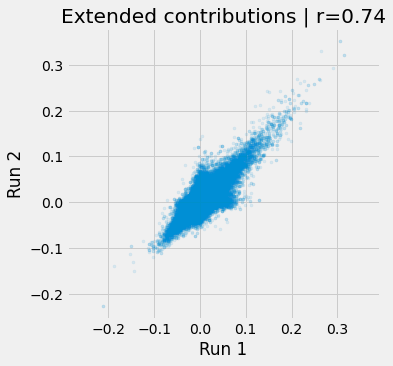

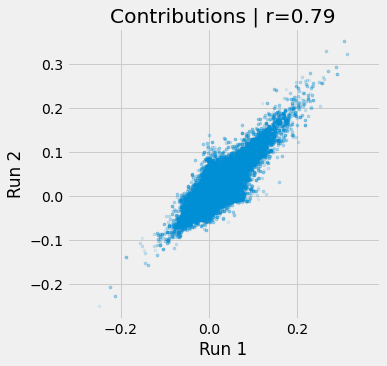

In [39]:
#x, y, = out_contributions_copy.flatten().numpy(), torch.Tensor(scores).flatten().numpy()
x, y, = out_contributions_copy.flatten().numpy(), out_contributions_copy_2.flatten().numpy()
pearson = np.round(np.corrcoef(x,y)[0,1], 2)

with plt.style.context('fivethirtyeight'):
    for i in range(1):
        random_slice = np.random.choice(x.shape[0], size=1000000)
        plt.figure(figsize=(5,5))
        plt.scatter(x=x[random_slice], y=y[random_slice], alpha=0.1, marker='.')
        plt.axis('equal')
        plt.xlabel('Run 1')
        plt.ylabel('Run 2')
        plt.title(f'Extended contributions | r={pearson}')
        plt.show()
        
x = (out_contributions_copy * onehot_seqs).sum(dim=2).flatten().numpy()
y = (out_contributions_copy_2 * onehot_seqs).sum(dim=2).flatten().numpy()
pearson = np.round(np.corrcoef(x,y)[0,1], 2)

with plt.style.context('fivethirtyeight'):
    for i in range(1):
        random_slice = np.random.choice(x.shape[0], size=1000000)
        plt.figure(figsize=(5,5))
        plt.scatter(x=x[random_slice], y=y[random_slice], alpha=0.1, marker='.')
        plt.axis('equal')
        plt.xlabel('Run 1')
        plt.ylabel('Run 2')
        plt.title(f'Contributions | r={pearson}')
        plt.show()

------ Sequnce 5652 / cell 2 -------


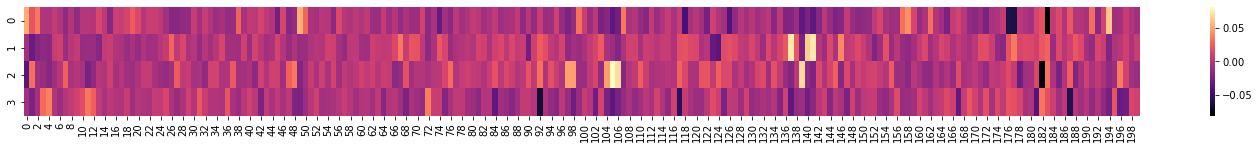

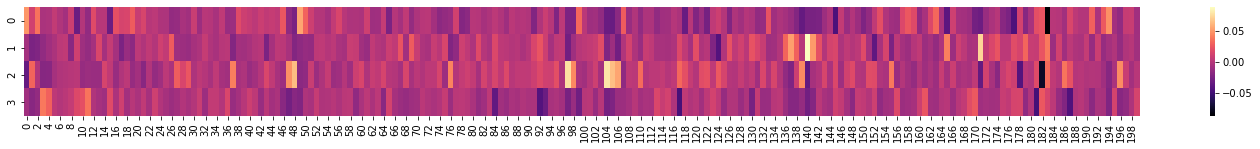

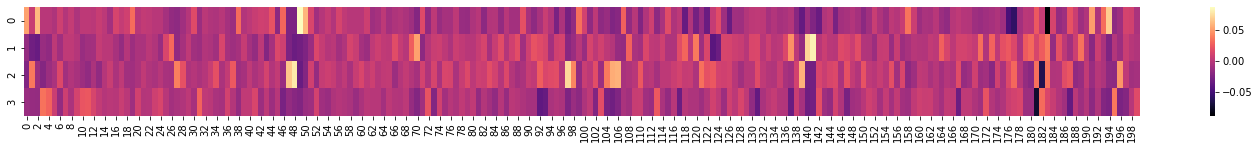

------ Sequnce 1675 / cell 0 -------


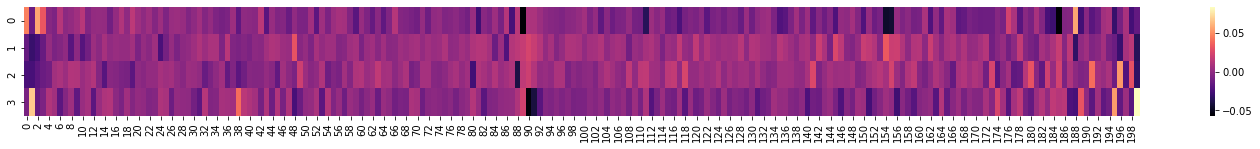

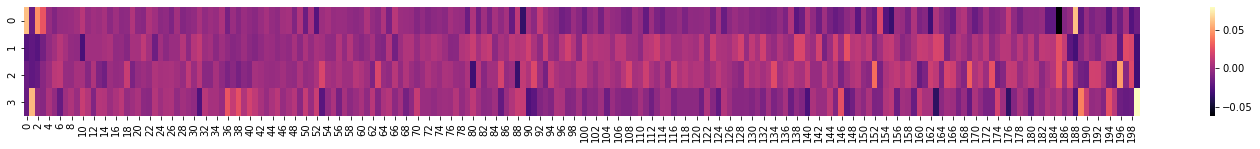

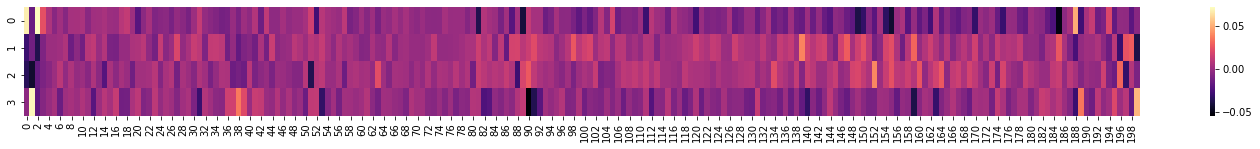

------ Sequnce 4660 / cell 1 -------


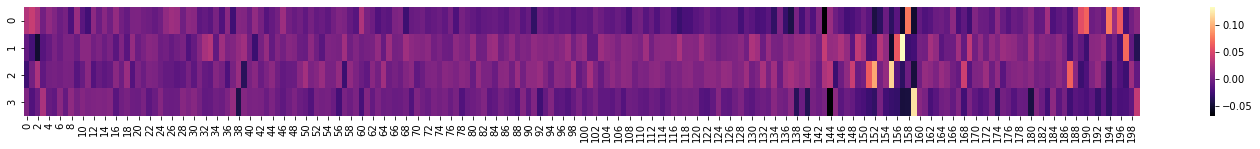

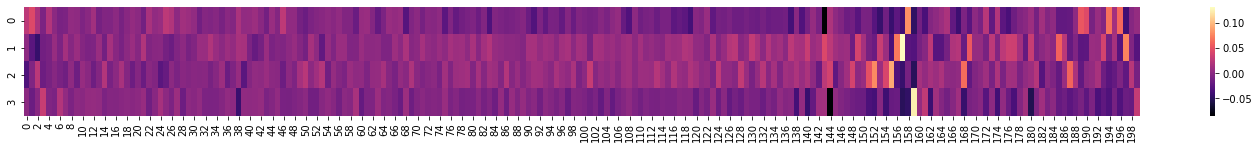

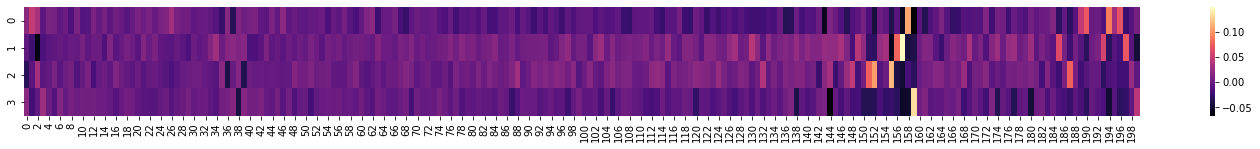

------ Sequnce 5822 / cell 2 -------


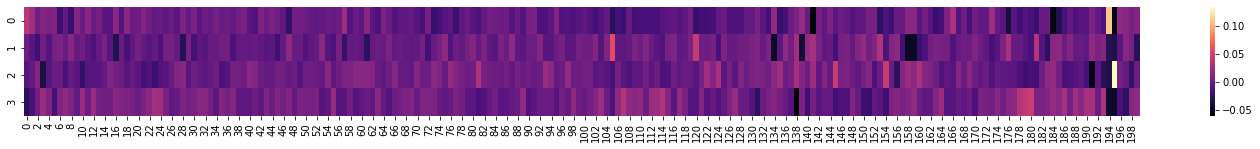

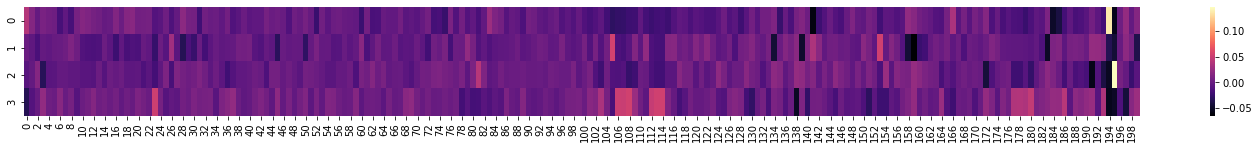

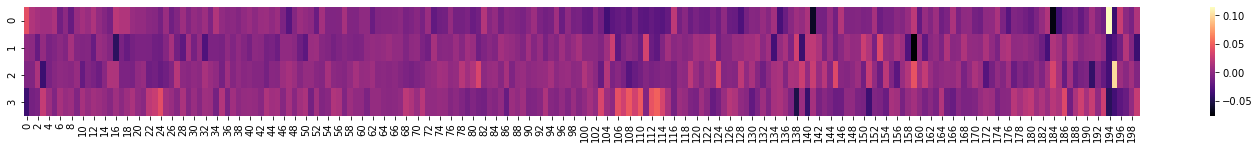

------ Sequnce 1028 / cell 0 -------


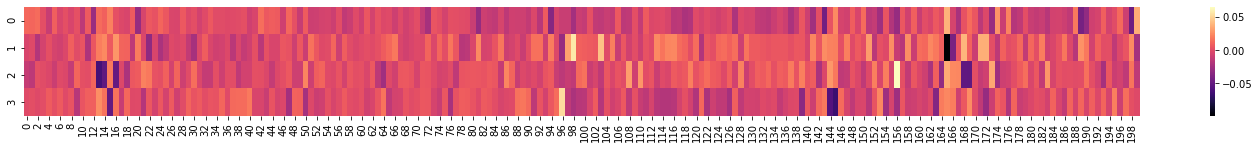

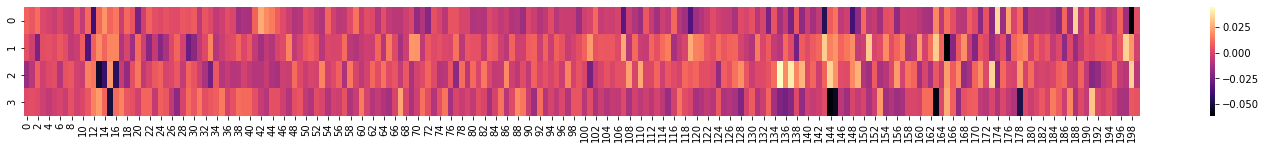

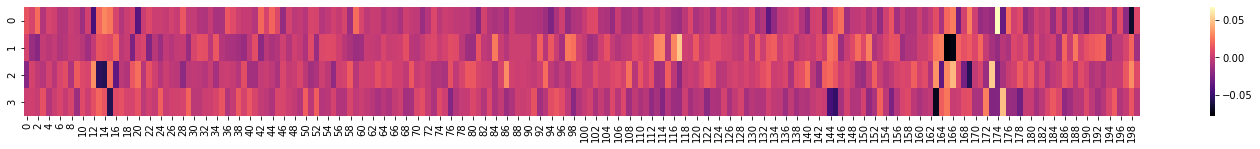

In [54]:
for n in range(5):
    i = np.random.randint(0, 6199)
    j = np.random.randint(0, 3)
    print(f'------ Sequnce {i} / cell {j} -------')
    
    plt.figure(figsize=(25,2))
    sns.heatmap(scores[i, ..., j], cmap="magma")
    plt.show()

    plt.figure(figsize=(25,2))
    sns.heatmap(out_contributions[j, i, ...], cmap="magma")
    plt.show()
    
    plt.figure(figsize=(25,2))
    sns.heatmap(out_contributions_2[j, i, ...], cmap="magma")
    plt.show()

In [16]:
# out_contributions_copy = out_contributions.clone()
# out_contributions_copy_2 = out_contributions_2.clone()
# out_contributions_copy.shape

torch.Size([3, 6199, 4, 200])

In [55]:
out_contributions_copy = out_contributions_copy.permute(1, 2, 3, 0)
out_contributions_copy_2 = out_contributions_copy_2.permute(1, 2, 3, 0)

scores.shape, out_contributions_copy.shape

((6199, 4, 200, 3), torch.Size([6199, 4, 200, 3]))

------ Sequence 6084 / cell 0 -------


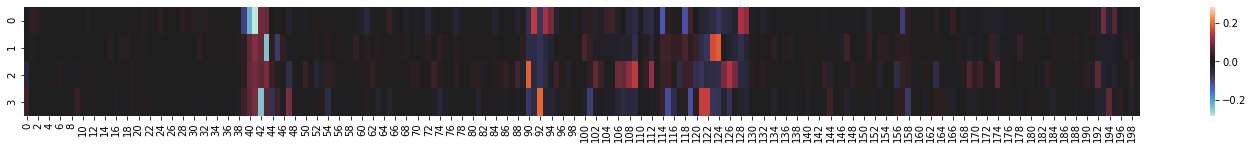

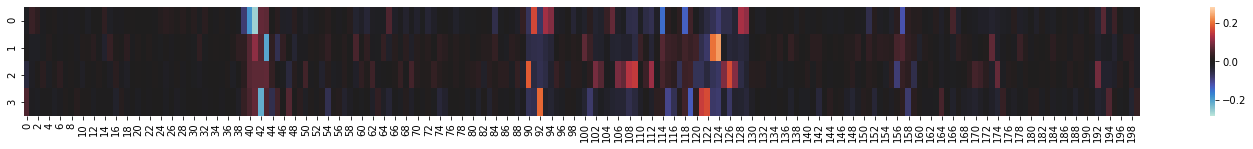

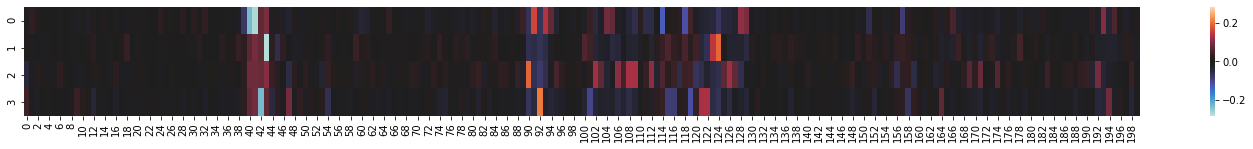

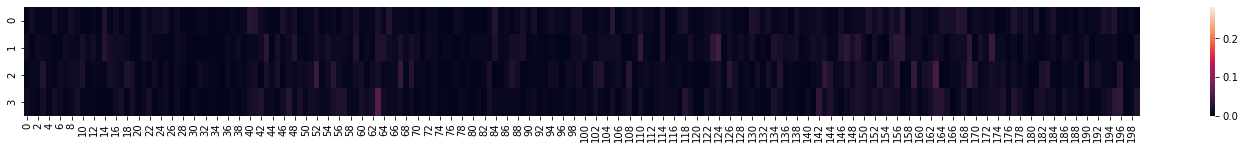

------ Sequence 149 / cell 0 -------


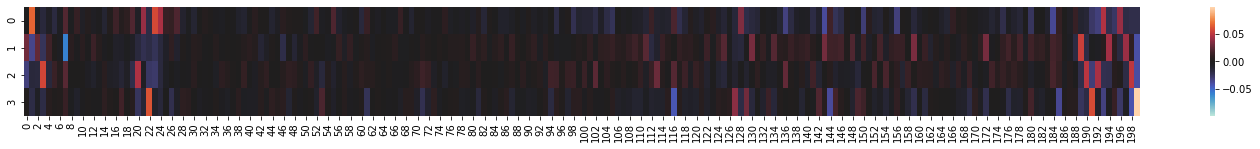

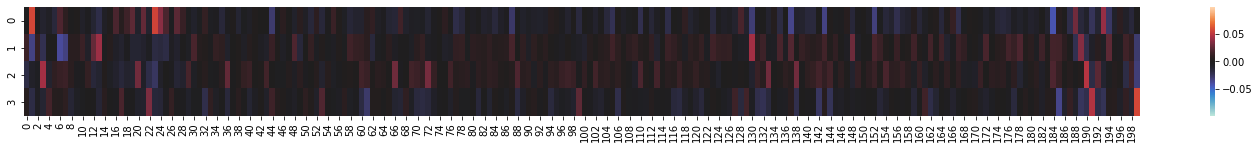

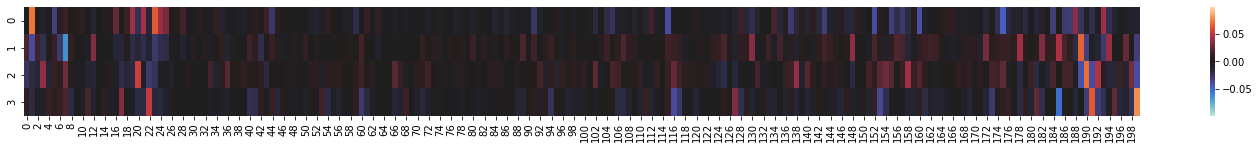

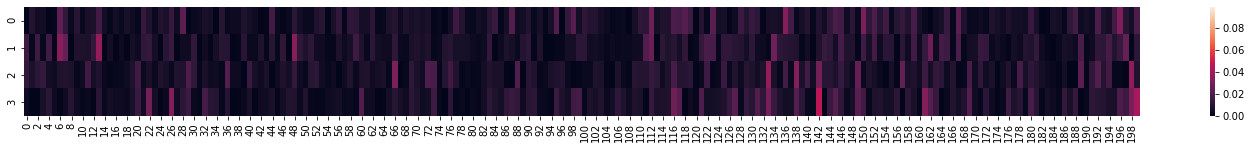

------ Sequence 4984 / cell 0 -------


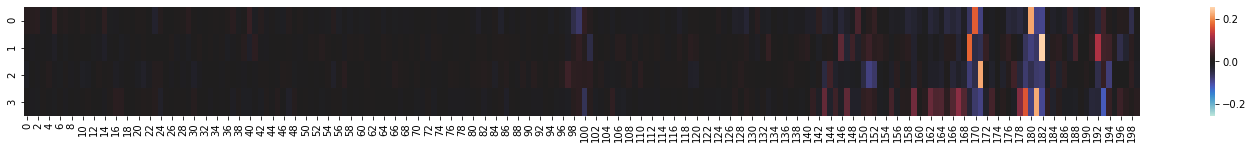

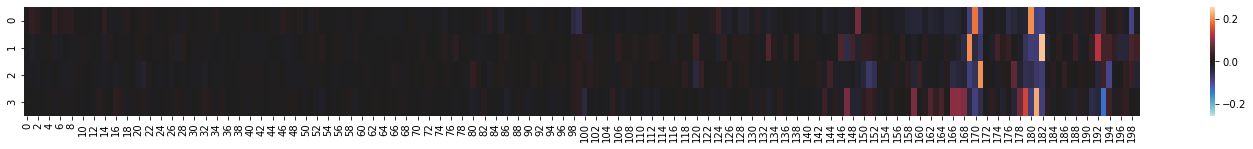

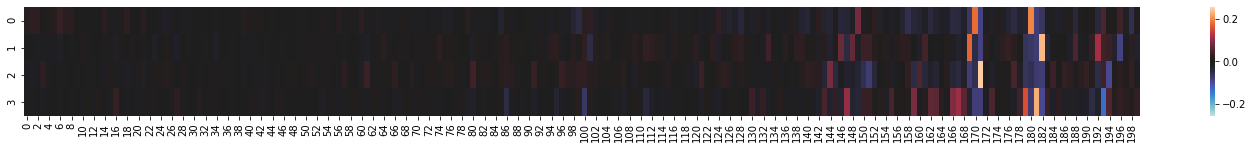

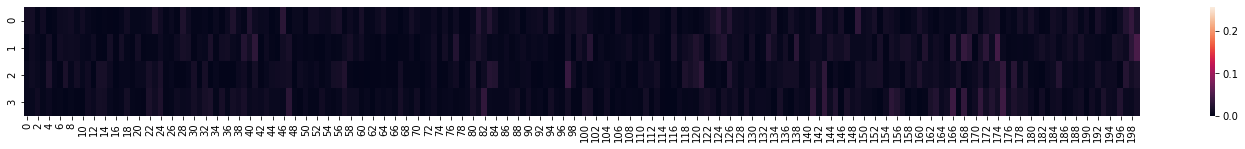

------ Sequence 1248 / cell 0 -------


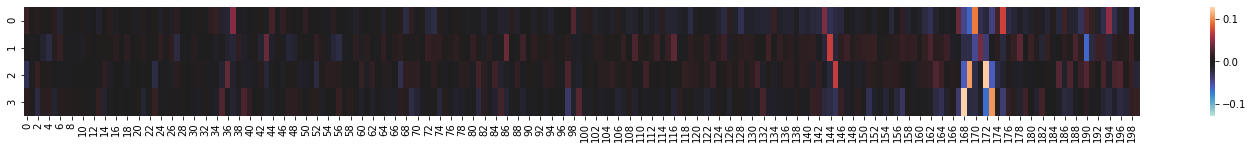

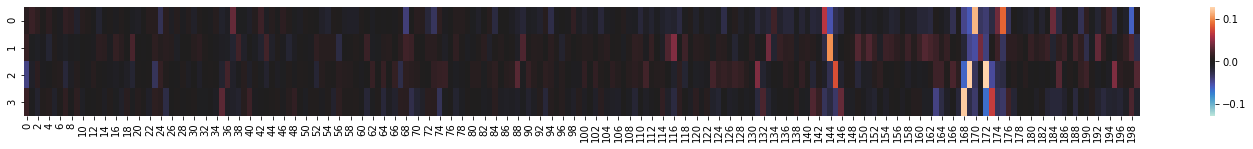

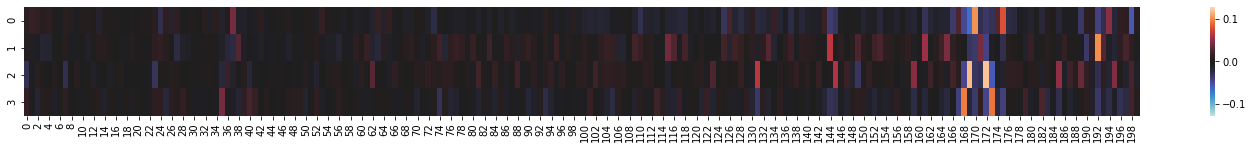

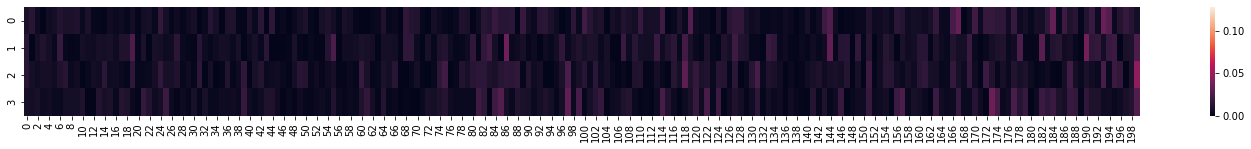

------ Sequence 2554 / cell 0 -------


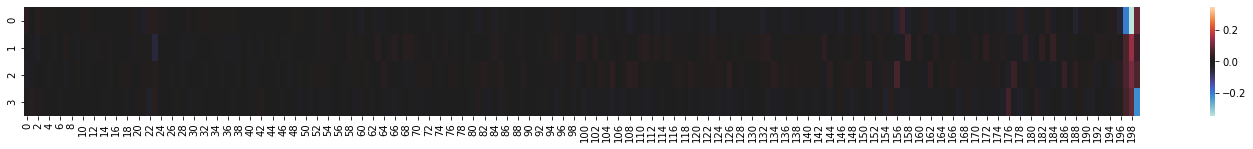

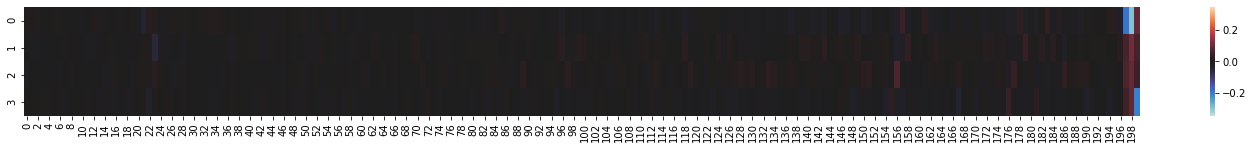

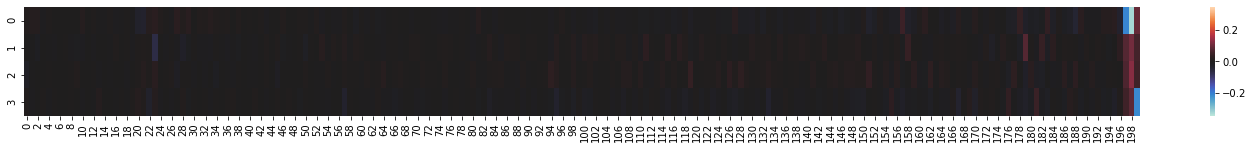

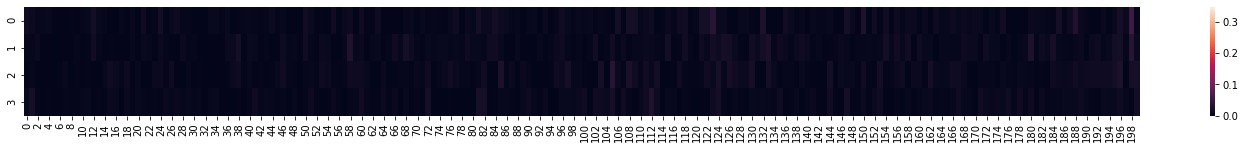

In [58]:
for n in range(5):
    i = np.random.randint(0, 6199)
    j = np.random.randint(0, 3)
    print(f'------ Sequence {i} / cell {j} -------')
    
    v_min = min(scores[i, ..., j].min(), out_contributions_copy[i, ..., j].min())
    v_max = max(scores[i, ..., j].max(), out_contributions_copy[i, ..., j].max())
    maxi = max(abs(v_min), v_max)
    
    plt.figure(figsize=(25,2))
    sns.heatmap(out_contributions_copy[i, ..., j], cmap="icefire", vmin=-maxi, vmax=maxi)
    plt.show()
    
    plt.figure(figsize=(25,2))
    sns.heatmap(out_contributions_copy_2[i, ..., j], cmap="icefire", vmin=-maxi, vmax=maxi)
    plt.show()
    
    plt.figure(figsize=(25,2))
    sns.heatmap(scores[i, ..., j], cmap="icefire", vmin=-maxi, vmax=maxi)
    plt.show()

    #plot_matrix = np.abs(out_contributions_copy[i, ..., j].numpy() - scores[i, ..., j])
    plot_matrix = (out_contributions_copy[i, ..., j] - out_contributions_copy_2[i, ..., j]).abs()
    plt.figure(figsize=(25,2))
    sns.heatmap(plot_matrix, cmap="rocket", vmin=0, vmax=maxi)
    plt.show()

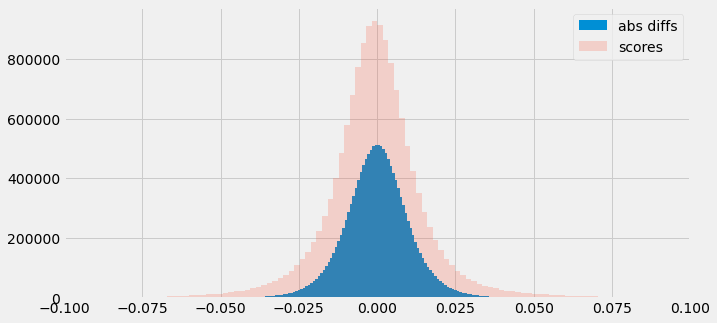

In [67]:
mapes = (out_contributions_copy - out_contributions_copy_2).flatten().numpy()
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(10,5))
    plt.hist(mapes, bins=500, label='abs diffs')
    plt.hist(out_contributions_copy_2.flatten().numpy(), bins=1000, alpha=0.2, label='scores')
    plt.legend()
    plt.xlim(-0.1, 0.1)
    plt.show()

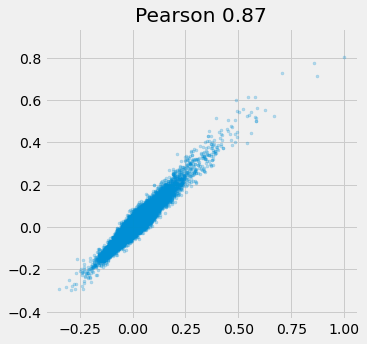

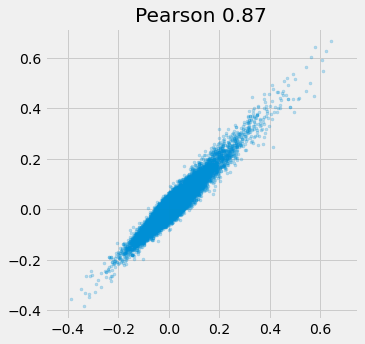

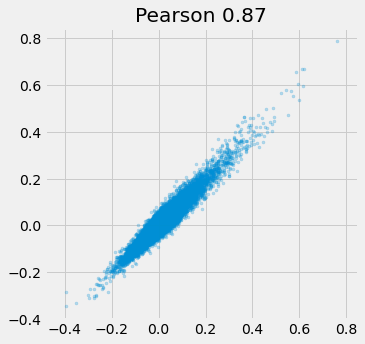

In [61]:
for i in range(1):
    #x, y, = out_contributions_copy.flatten().numpy(), torch.Tensor(scores).flatten().numpy()
    x, y, = out_contributions_copy.flatten().numpy(), out_contributions_copy_2.flatten().numpy()
    random_slice = np.random.choice(x.shape[0], size=500000)
    pearson = np.round(np.corrcoef(x,y)[0,1], 2)

    with plt.style.context('fivethirtyeight'):
        plt.figure(figsize=(5,5))
        plt.scatter(x=x[random_slice], y=y[random_slice], alpha=0.25, marker='.')
        plt.axis('equal')
#         plt.xlabel('Old way')
#         plt.ylabel('New way')
        plt.title(f'Pearson {pearson}')
        plt.show()
        
    x, y, = out_contributions_copy.flatten().numpy(), torch.Tensor(scores).flatten().numpy()
    #x, y, = out_contributions_copy.flatten().numpy(), out_contributions_copy_2.flatten().numpy()
    random_slice = np.random.choice(x.shape[0], size=500000)
    pearson = np.round(np.corrcoef(x,y)[0,1], 2)

    with plt.style.context('fivethirtyeight'):
        plt.figure(figsize=(5,5))
        plt.scatter(x=x[random_slice], y=y[random_slice], alpha=0.25, marker='.')
        plt.axis('equal')
#         plt.xlabel('Old way')
#         plt.ylabel('New way')
        plt.title(f'Pearson {pearson}')
        plt.show()
        
    x, y, = out_contributions_copy_2.flatten().numpy(), torch.Tensor(scores).flatten().numpy()
    #x, y, = out_contributions_copy.flatten().numpy(), out_contributions_copy_2.flatten().numpy()
    random_slice = np.random.choice(x.shape[0], size=500000)
    pearson = np.round(np.corrcoef(x,y)[0,1], 2)

    with plt.style.context('fivethirtyeight'):
        plt.figure(figsize=(5,5))
        plt.scatter(x=x[random_slice], y=y[random_slice], alpha=0.25, marker='.')
        plt.axis('equal')
#         plt.xlabel('Old way')
#         plt.ylabel('New way')
        plt.title(f'Pearson {pearson}')
        plt.show()

In [62]:
onehot_seqs = example_batch.clone()
onehot_seqs = onehot_seqs.repeat(3,1,1,1).permute(1, 2, 3, 0)

onehot_seqs.shape

torch.Size([6199, 4, 200, 3])

In [63]:
true_scores = scores * onehot_seqs.numpy()
true_contributions = out_contributions_copy * onehot_seqs
true_contributions_2 = out_contributions_copy_2 * onehot_seqs

------ Sequnce 4830 / cell 0 -------


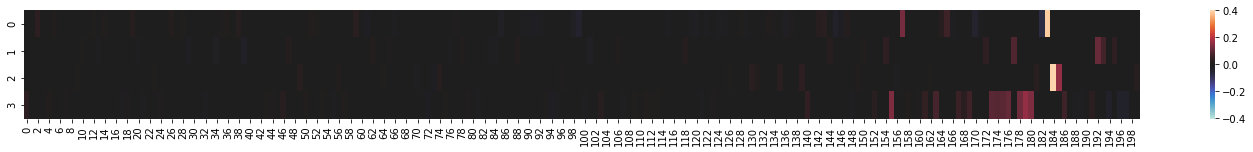

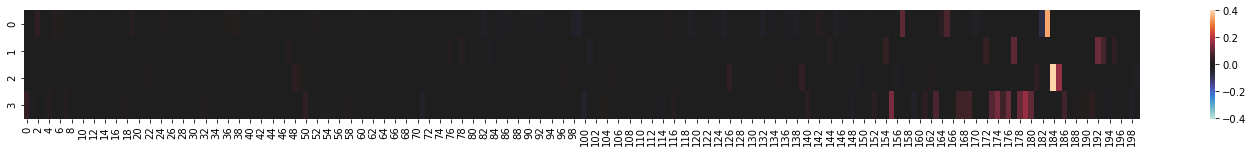

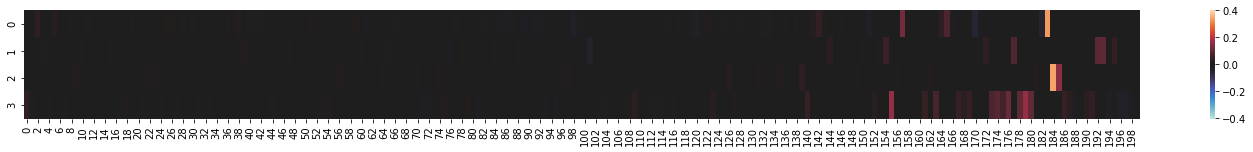

------ Sequnce 1771 / cell 0 -------


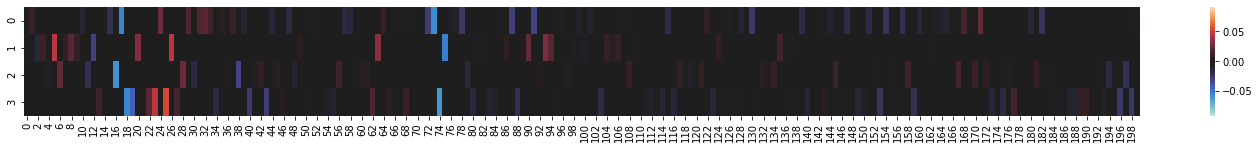

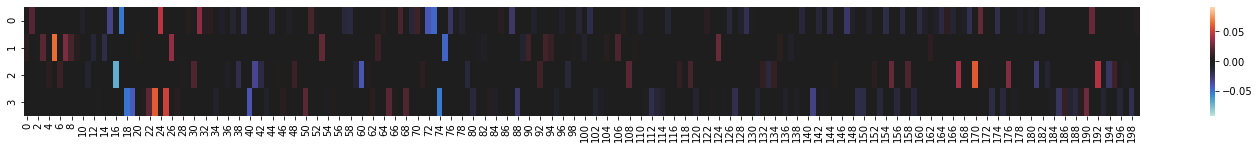

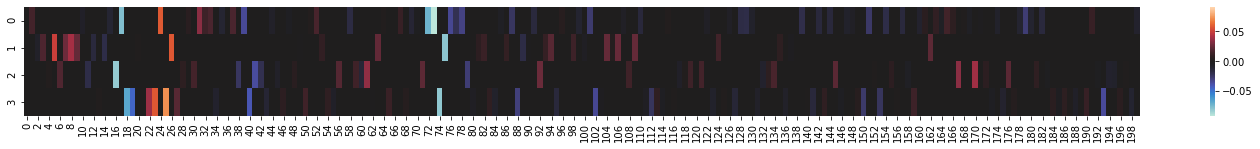

------ Sequnce 250 / cell 0 -------


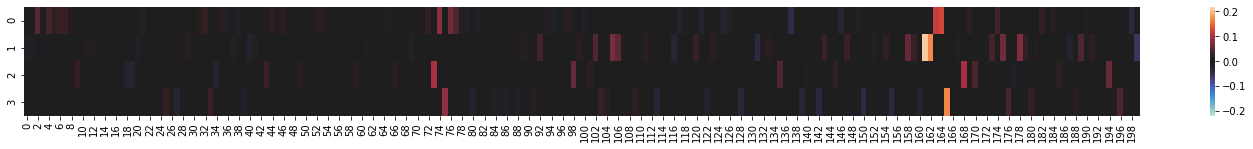

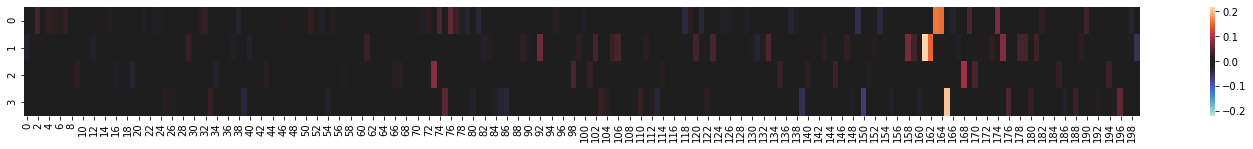

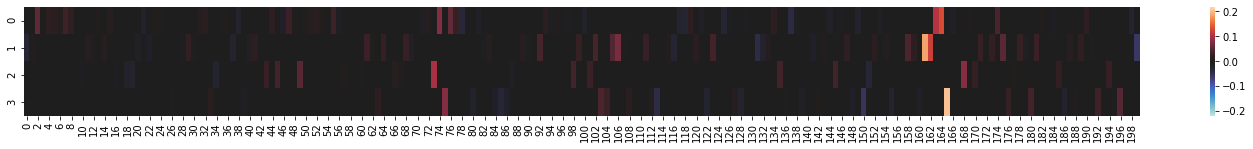

------ Sequnce 3419 / cell 1 -------


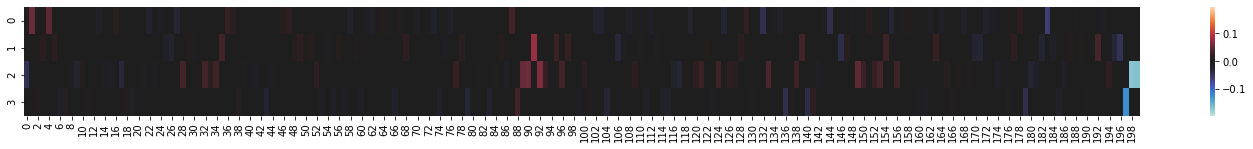

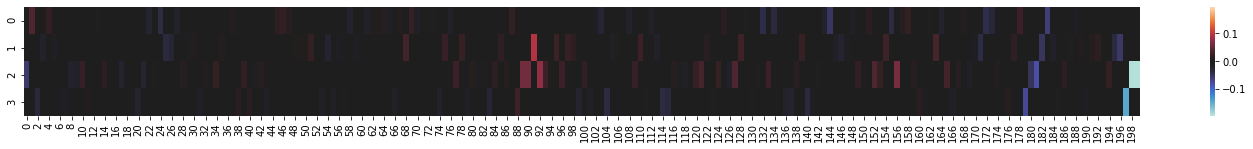

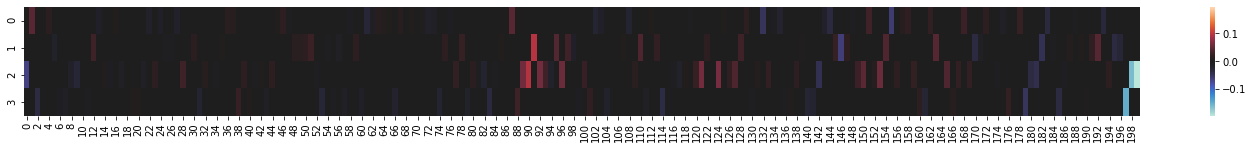

In [64]:
for n in range(4):
    i = np.random.randint(0, 6199)
    j = np.random.randint(0, 3)
    print(f'------ Sequnce {i} / cell {j} -------')
    
    v_min = min(true_scores[i, ..., j].min(), true_contributions[i, ..., j].min(), true_contributions_2[i, ..., j].min())
    v_max = max(true_scores[i, ..., j].max(), true_contributions[i, ..., j].max(), true_contributions_2[i, ..., j].max())
    maxi = max(abs(v_min), v_max)
    
    plt.figure(figsize=(25,2))
    sns.heatmap(true_contributions[i, ..., j], cmap="icefire", vmin=-maxi, vmax=maxi)
    plt.show()
    
    plt.figure(figsize=(25,2))
    sns.heatmap(true_contributions_2[i, ..., j], cmap="icefire", vmin=-maxi, vmax=maxi)
    plt.show()
    
    plt.figure(figsize=(25,2))
    sns.heatmap(true_scores[i, ..., j], cmap="icefire", vmin=-maxi, vmax=maxi)
    plt.show()

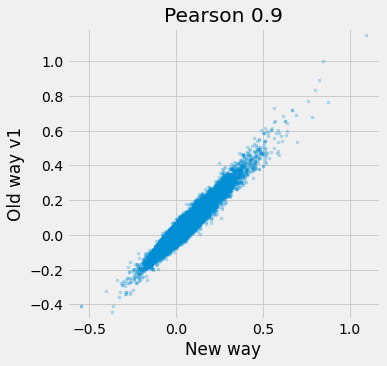

0.9


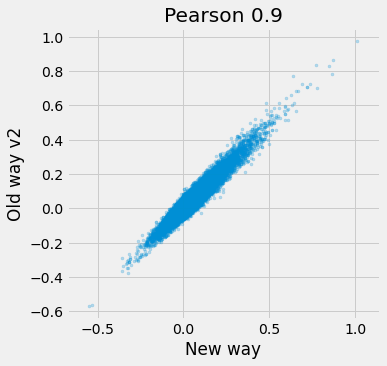

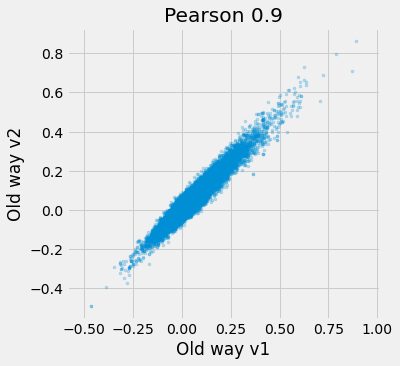

In [68]:
x = torch.Tensor(true_scores).sum(dim=1).flatten().numpy()
y = true_contributions.sum(dim=1).flatten().numpy()
pearson = np.round(np.corrcoef(x,y)[0,1], 2)

random_slice = np.random.choice(x.shape[0], size=500000)
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(5,5))
    plt.scatter(x=x[random_slice], y=y[random_slice], alpha=0.25, marker='.')
    plt.axis('equal')
    plt.xlabel('New way')
    plt.ylabel('Old way v1')
    plt.title(f'Pearson {pearson}')
    plt.show()
        
print(np.round(np.corrcoef(x,y)[0,1], 2))

x = torch.Tensor(true_scores).sum(dim=1).flatten().numpy()
y = true_contributions_2.sum(dim=1).flatten().numpy()
pearson = np.round(np.corrcoef(x,y)[0,1], 2)

random_slice = np.random.choice(x.shape[0], size=500000)
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(5,5))
    plt.scatter(x=x[random_slice], y=y[random_slice], alpha=0.25, marker='.')
    plt.axis('equal')
    plt.xlabel('New way')
    plt.ylabel('Old way v2')
    plt.title(f'Pearson {pearson}')
    plt.show()

x = true_contributions.sum(dim=1).flatten().numpy()
y = true_contributions_2.sum(dim=1).flatten().numpy()
pearson = np.round(np.corrcoef(x,y)[0,1], 2)

random_slice = np.random.choice(x.shape[0], size=500000)
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(5,5))
    plt.scatter(x=x[random_slice], y=y[random_slice], alpha=0.25, marker='.')
    plt.axis('equal')
    plt.xlabel('Old way v1')
    plt.ylabel('Old way v2')
    plt.title(f'Pearson {pearson}')
    plt.show()

In [69]:
x = torch.Tensor(true_scores).sum(dim=1).flatten().numpy()
y = true_contributions.sum(dim=1).flatten().numpy()
print(np.abs(x - y).mean())
print((np.abs(x - y) / np.abs(y)).mean())

x = torch.Tensor(true_scores).sum(dim=1).flatten().numpy()
y = true_contributions_2.sum(dim=1).flatten().numpy()
print(np.abs(x - y).mean())
print((np.abs(x - y) / np.abs(y)).mean())

x = true_contributions.sum(dim=1).flatten().numpy()
y = true_contributions_2.sum(dim=1).flatten().numpy()

print(np.abs(x - y).mean())
print((np.abs(x - y) / np.abs(y)).mean())

0.011889053
5.21554
0.011891806
6.509408
0.011880105
7.4228597


In [55]:
print((np.abs(x - y) / np.abs(x)).mean())

6.0565877
